# Operation Time Extrapolation

In [1]:
import os
import pandas as pd
import re
import numpy as np
import sklearn.metrics

In [2]:
DATAPOINTS_DIR = "datapoints/Experiment data 2023"
OP_EXEC_TIME_RESULTS_DIR = "avg_time_operation_results"
CPU_DIR = "cpu"
GPU_DIR = "gpu"
ROUND_1_DIR = "round1"
ROUND_2_DIR = "round2"
NUM_CLIENTS_DIR = "num_clients"
CURR_DIR = os.getcwd()

In [3]:
NUM_CPU_EXT = "_num_cpu.npy"
NUM_GPU_EXT = "_num_gpu.npy"
NUM_CLIENTS_EXT = "_num_clients.npy"
ROUND_1_EXT = "_round_1"
ROUND_2_EXT = "_round_2"
OP_NAMES_FILE = "operation_names.npy"

In [4]:
datapoints_folder = os.path.join(CURR_DIR, DATAPOINTS_DIR)
op_exec_time_results_folder = os.path.join(datapoints_folder, OP_EXEC_TIME_RESULTS_DIR)
if not os.path.exists(op_exec_time_results_folder):
    os.mkdir(op_exec_time_results_folder)

In [5]:
frame_model_detection_label = 'send frame to model for detection'
list_of_operations = ['decoding from base64', 'Buffer encoding time', 'numpy array to opencv image', 'send frame to model for detection', 'frame detection finished', 'end computation in detector']
frame_model_detection_label_index = [i for i in range(len(list_of_operations)) if list_of_operations[i] == frame_model_detection_label][0]
list_of_operations_counter = [0, 0, 0, 0, 0, 0]

In [6]:
list_of_operations_filepath = os.path.join(op_exec_time_results_folder, OP_NAMES_FILE)
if not os.path.isfile(list_of_operations_filepath):
    np.save(list_of_operations_filepath, list_of_operations)

In [7]:
num_clients_datapoints_folder = os.path.join(datapoints_folder, NUM_CLIENTS_DIR)
num_cpu_datapoints_folder = os.path.join(datapoints_folder, CPU_DIR)
num_gpu_datapoints_folder = os.path.join(datapoints_folder, GPU_DIR)
round_1_num_clients_datapoints_folder = os.path.join(num_clients_datapoints_folder, ROUND_1_DIR)
round_2_num_clients_datapoints_folder = os.path.join(num_clients_datapoints_folder, ROUND_2_DIR)

In [28]:
def get_exec_op_time(datapoint_file_path):
    datapoints_df = pd.DataFrame
    try:
        datapoints_df = pd.read_csv(datapoint_file_path, on_bad_lines='skip', engine='python')
    except Exception as e:
        print("Error:", str(e))
    datapoints_df_pyServer = datapoints_df[datapoints_df['Service'] == 'pyServer']
    datapoints_df_pyServer = datapoints_df_pyServer.drop(['Operation Name', 'Service'], axis=1)
    duration_array = datapoints_df_pyServer['Duration'].values
    timestamp_array = datapoints_df_pyServer['Logs'].values
    set_of_operations_count = len(timestamp_array)
    operations_df_array = []
    set_of_operations_counter = 0
    for set_of_operations in timestamp_array:
        operations = re.findall(r"log\(ts=(\d+).*?value_string='(.*?)'",set_of_operations)
        operations_df_data = []
        for operation in operations:
            operation_timestamp = int(operation[0])
            operation_name = operation[1]
            operations_df_data.append({'timestamp': operation_timestamp, 'operation_name': operation_name})
        operations_df = pd.DataFrame(operations_df_data)
        operations_df['operation_time'] = operations_df['timestamp'].shift(-1) - operations_df['timestamp']
        operations_df.iloc[-1, -1] = duration_array[set_of_operations_counter] - operations_df['operation_time'].sum()
        operations_df.drop('timestamp', axis=1, inplace=True)
        operations_df_array.append(operations_df)
        set_of_operations_counter += 1
    for operations_df in operations_df_array:
        operation_counter = 0
        for list_of_operations_name in list_of_operations:
            operation_row = operations_df.loc[operations_df['operation_name'] == list_of_operations_name]
            operation_row_time = operation_row['operation_time'].values[0]
            list_of_operations_counter[operation_counter] += operation_row_time
            operation_counter += 1
    avg_time_list_of_operations = [operation_counter / set_of_operations_count for operation_counter in list_of_operations_counter]
    return avg_time_list_of_operations

In [32]:
all_datapoints = os.listdir(round_2_num_clients_datapoints_folder) # change folder name here
num_datapoints = len(all_datapoints)
datapoints_counter = 1
for datapoint in all_datapoints:
    print(datapoint)
    datapoint_file_path = os.path.join(round_2_num_clients_datapoints_folder, datapoint) # change folder name here
    avg_exec_time_all_operations = get_exec_op_time(datapoint_file_path)
    print(f'{datapoints_counter}/{num_datapoints}: {avg_exec_time_all_operations}')
    datapoint_filename = os.path.splitext(datapoint)[0]
    datapoint_results_filepath = os.path.join(op_exec_time_results_folder, datapoint_filename + ROUND_2_EXT + NUM_CLIENTS_EXT) # change name to correspond with folder
    if not os.path.isfile(datapoint_results_filepath):
        np.save(datapoint_results_filepath, avg_exec_time_all_operations)
    datapoints_counter += 1

client_1_memory_16g_cpu_6_data_points.csv
1/4: [2682503.4834437086, 7064.140728476821, 4487444.61589404, 109555938.43791391, 6585.752483443709, 216897.0894039735]
client_2_memory_16g_cpu_6_data_points.csv
2/4: [4251623.806744488, 11108.594033722438, 7052847.732814526, 171732641.73929963, 10367.622568093386, 341634.58365758753]
client_4_memory_16g_cpu_6_data_points.csv
3/4: [1002613.9168126094, 2552.713368359603, 1624834.7551079977, 38954758.20402802, 2468.25685931115, 81353.16433158203]
client_5_memory_16g_cpu_6_data_points.csv
4/4: [1662991.0023584906, 4183.183962264151, 2671060.324056604, 63431306.915566035, 4086.4990566037736, 137470.36273584905]


In [8]:
avg_exec_time_ops_list = os.listdir(op_exec_time_results_folder)
num_cpu_avg_exec_time_ops_list = [f for f in avg_exec_time_ops_list if f.endswith(NUM_CPU_EXT)]
num_clients_avg_exec_time_ops_list = [f for f in avg_exec_time_ops_list if f.endswith(NUM_CLIENTS_EXT)]
num_gpu_avg_exec_time_ops_list = [f for f in avg_exec_time_ops_list if f.endswith(NUM_GPU_EXT)]
if len(avg_exec_time_ops_list) == len(num_gpu_avg_exec_time_ops_list) + len(num_clients_avg_exec_time_ops_list) + len(num_cpu_avg_exec_time_ops_list) + 1:
    print("equal")
else:
    print("unequal")

equal


In [9]:
num_clients_avg_exec_time_ops_list

['client_1_memory_16g_cpu_6_data_points_round_1_num_clients.npy',
 'client_1_memory_16g_cpu_6_data_points_round_2_num_clients.npy',
 'client_2_memory_16g_cpu_6_data_points_round_1_num_clients.npy',
 'client_2_memory_16g_cpu_6_data_points_round_2_num_clients.npy',
 'client_3_memory_16g_cpu_6_data_points_round_1_num_clients.npy',
 'client_4_memory_16g_cpu_6_data_points_round_1_num_clients.npy',
 'client_4_memory_16g_cpu_6_data_points_round_2_num_clients.npy',
 'client_5_memory_16g_cpu_6_data_points_round_1_num_clients.npy',
 'client_5_memory_16g_cpu_6_data_points_round_2_num_clients.npy',
 'client_6_memory_16g_cpu_6_data_points_round_1_num_clients.npy']

In [10]:
num_cpu_client_num_client = []
num_cpu_client_num_cpu = []
num_cpu_client_num_mem = []
num_cpu_client_num_gpu = []
num_cpu_client_frame_model_detection_time = []

num_cpu_num_client_regex = re.compile(r"client_(\d+)")
num_cpu_num_cpu_regex = re.compile(r"cpu_(\d+)m")
num_cpu_num_mem_regex = re.compile(r"mem_(\d+)")
num_cpu_num_gpu_regex = re.compile(r"gpu_(\d+)")

for file_name in num_cpu_avg_exec_time_ops_list:
    num_client = int(num_cpu_num_client_regex.search(file_name).group(1))
    num_cpu = float(num_cpu_num_cpu_regex.search(file_name).group(1)) / 1000
    num_mem = int(num_cpu_num_mem_regex.search(file_name).group(1))
    num_gpu = int(num_cpu_num_gpu_regex.search(file_name).group(1))

    num_cpu_client_num_client.append(num_client)
    num_cpu_client_num_cpu.append(num_cpu)
    num_cpu_client_num_mem.append(num_mem)
    num_cpu_client_num_gpu.append(num_gpu)

    avg_exec_time_op_filepath = os.path.join(op_exec_time_results_folder, file_name)
    avg_exec_time_op = np.load(avg_exec_time_op_filepath)
    num_cpu_client_frame_model_detection_time.append(avg_exec_time_op[frame_model_detection_label_index])

num_client_num_client_regex = re.compile(r"client_(\d+)")
num_client_num_cpu_regex = re.compile(r"cpu_(\d+)")
num_client_num_mem_regex = re.compile(r"memory_(\d+)g")
# num_client_num_gpu_regex = re.compile(r"gpu_(\d+)")

for file_name in num_clients_avg_exec_time_ops_list:
    num_client = int(num_client_num_client_regex.search(file_name).group(1))
    num_cpu = int(num_client_num_cpu_regex.search(file_name).group(1))
    num_mem = int(num_client_num_mem_regex.search(file_name).group(1))
    # num_gpu = int(num_client_num_gpu_regex.search(file_name).group(1))

    num_cpu_client_num_client.append(num_client)
    num_cpu_client_num_cpu.append(num_cpu)
    num_cpu_client_num_mem.append(num_mem)
    num_cpu_client_num_gpu.append(0) # always 0 GPU

    avg_exec_time_op_filepath = os.path.join(op_exec_time_results_folder, file_name)
    avg_exec_time_op = np.load(avg_exec_time_op_filepath)
    num_cpu_client_frame_model_detection_time.append(avg_exec_time_op[frame_model_detection_label_index])


print("Num Clients: ", num_cpu_client_num_client)
print("Num CPUs: ", num_cpu_client_num_cpu)
print("Num MEMs: ", num_cpu_client_num_mem)
print("Num GPUs: ", num_cpu_client_num_gpu)
print("Frame Model Detection Times: ", num_cpu_client_frame_model_detection_time)

Num Clients:  [1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 1, 1, 2, 2, 3, 4, 4, 5, 5, 6]
Num CPUs:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 1.0, 1.0, 0.1, 0.1, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 1.0, 2.0, 3.0, 4.0, 6.0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Num MEMs:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Num GPUs:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Frame Model Detection Times:  [1261228.1432119205, 1590848.1738410597, 1814768.4750430293, 3870867.134790528, 7206103.257985258, 5466693.640728476, 3756928.7795575894, 4995258.810831427, 17986950.56332491, 32295841.98539736, 105122552.87534122, 105599524.94085532, 194038047.76460767, 194330055.61268783, 258880238.67555556, 259085581.10222223, 73020077.531875, 73172335.37875, 38474667.16333224, 38551257.381436534, 64448570.27509294, 75509395

# Operation Time Prediction

In [11]:
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [12]:
X = np.column_stack((num_cpu_client_num_client, num_cpu_client_num_cpu, num_cpu_client_num_mem, num_cpu_client_num_gpu))
y = np.array(num_cpu_client_frame_model_detection_time).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_test)

[[ 1.   6.  16.   0. ]
 [ 3.   3.  16.   0. ]
 [ 5.   6.  16.   0. ]
 [ 5.   2.  16.   0. ]
 [ 3.   4.  16.   0. ]
 [ 3.   6.  16.   0. ]
 [ 3.   6.  16.   0. ]
 [ 3.   3.  16.   0. ]
 [ 3.   0.1 16.   0. ]
 [ 3.   5.  16.   0. ]
 [ 3.   0.1 16.   0. ]
 [ 5.   6.  16.   0. ]
 [ 1.   1.  16.   0. ]
 [ 1.   5.  16.   0. ]
 [ 3.   5.  16.   0. ]
 [ 2.   6.  16.   0. ]
 [ 1.   6.  16.   0. ]
 [ 3.   2.  16.   0. ]]


In [13]:
def plot_model(y_pred, title):
    residuals = np.abs(y_test - y_pred)
    scatter = plt.scatter(y_test, y_pred)
    plt.errorbar(y_test, y_pred, yerr=residuals, fmt='none', ecolor='red', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')

    handles = [scatter, plt.Line2D([0], [0], color='blue', linestyle='--'), plt.Line2D([0], [0], color='red')]
    labels = ['Data Points', 'Line of Best Fit', 'Error Bars']
    plt.legend(handles, labels, loc='upper left')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title + ' - Actual vs Predicted')
    plt.show()

In [18]:
def plot_model_3d(y_pred, title, is_gpu):
    num_clients = X_test[:, 0]
    num_gpu_cpus = []
    title_gpu_cpu = ''

    if is_gpu:
        title_gpu_cpu = 'GPU'
        num_gpu_cpus = X_test[:, 3]
    else:
        title_gpu_cpu = 'CPU'
        num_gpu_cpus = X_test[:, 1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(num_clients, num_gpu_cpus, y_pred, c='red', label='Predicted')
    ax.scatter(num_clients, num_gpu_cpus, y_test, c='blue', label='Actual')

    ax.set_xlabel('Number Of Clients')
    ax.set_ylabel('Number of ' + title_gpu_cpu + 's')
    ax.set_zlabel('Predicted Detection Time')
    ax.set_title('Relationship Between Number of Clients, Number of ' + title_gpu_cpu + 's, and Predicted Detection Time - ' + title)
    ax.legend()

    ax.view_init(elev=30, azim=45)  # set the elevation and azimuth angles

    plt.show()

In [20]:
mean_value = np.mean(y_train)
median_value = np.median(y_train)
y_pred_mean = np.empty(len(y_test))
y_pred_median = np.empty(len(y_test))
y_pred_mean = np.full_like(y_pred_mean, mean_value)
y_pred_median = np.full_like(y_pred_median, median_value)
mean_r2_score = r2_score(y_test, y_pred_mean)
median_r2_score = r2_score(y_test, y_pred_median)
print("Mean R-squared score:", mean_r2_score)
print("Median R-squared score:", median_r2_score)

Mean R-squared score: -0.0001741247538198376
Median R-squared score: -0.2167568343171995


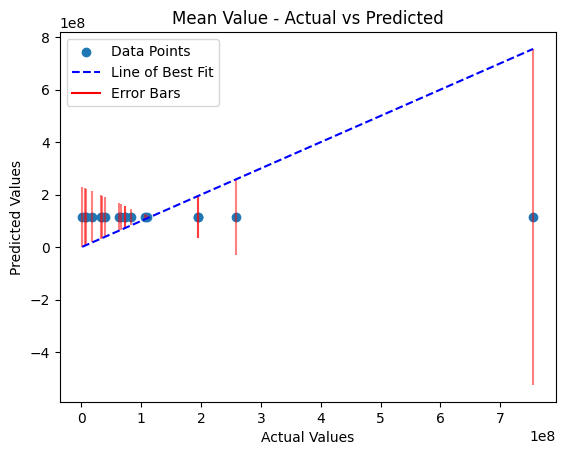

In [21]:
plot_model(y_pred_mean, "Mean Value")

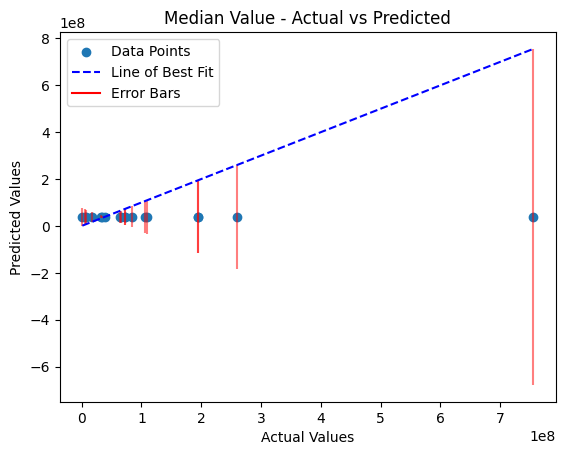

In [22]:
plot_model(y_pred_median, "Median Value")

In [23]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred_lin_reg = lin_reg_model.predict(X_test)
print("R-squared score:", r2_score(y_test, y_pred_lin_reg))

R-squared score: 0.2175698502351323


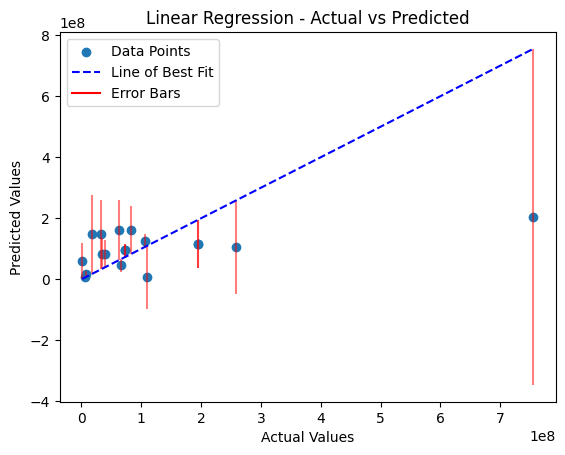

In [24]:
plot_model(y_pred_lin_reg, "Linear Regression")

In [25]:
poly_2d = PolynomialFeatures(degree=2, include_bias=True)
X_poly_2d_train = poly_2d.fit_transform(X_train)
X_poly_2d_test = poly_2d.transform(X_test)
poly_2d_reg_model = LinearRegression()
poly_2d_reg_model.fit(X_poly_2d_train, y_train)
y_pred_2d = poly_2d_reg_model.predict(X_poly_2d_test)
print("R-squared score: ", r2_score(y_test, y_pred_2d))

R-squared score:  -0.08206760498651833


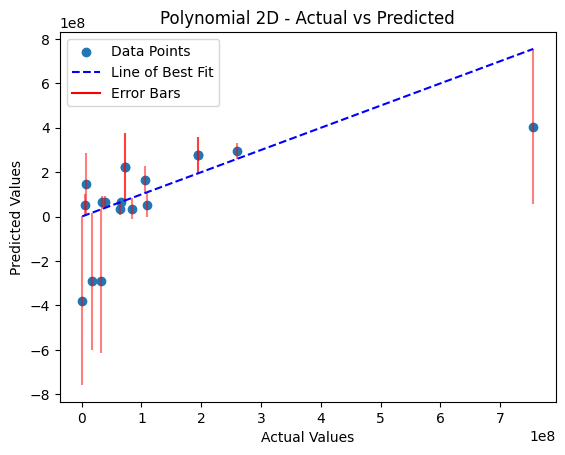

In [26]:
plot_model(y_pred_2d, "Polynomial 2D")

In [27]:
poly_3d = PolynomialFeatures(degree=3, include_bias=False)
X_poly_3d_train = poly_3d.fit_transform(X_train)
X_poly_3d_test = poly_3d.transform(X_test)
poly_3d_reg_model = LinearRegression()
poly_3d_reg_model.fit(X_poly_3d_train, y_train)
y_pred_3d = poly_3d_reg_model.predict(X_poly_3d_test)
print("R-squared score: ", r2_score(y_test, y_pred_3d))

R-squared score:  -3.8662969251573465


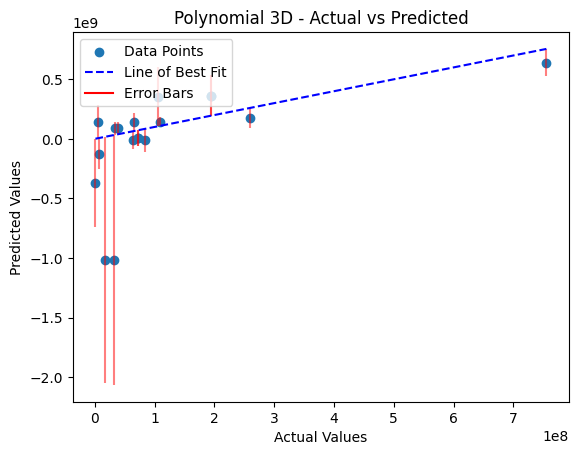

In [28]:
plot_model(y_pred_3d, "Polynomial 3D")

In [29]:
poly_4d = PolynomialFeatures(degree=4, include_bias = False)
X_poly_4d_train = poly_4d.fit_transform(X_train)
X_poly_4d_test = poly_4d.transform(X_test)
poly_4d_reg_model = LinearRegression()
poly_4d_reg_model.fit(X_poly_4d_train, y_train)
y_pred_4d = poly_4d_reg_model.predict(X_poly_4d_test)
print("R-squared score: ", r2_score(y_test, y_pred_4d))

R-squared score:  -28.528363175760138


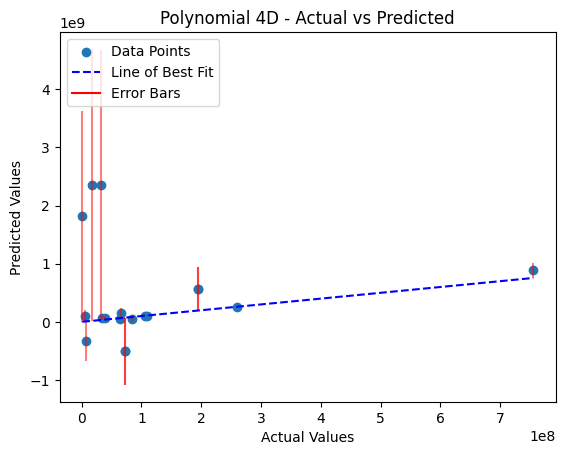

In [30]:
plot_model(y_pred_4d, "Polynomial 4D")

In [31]:
poly_5d = PolynomialFeatures(degree=5, include_bias = False)
X_poly_5d_train = poly_5d.fit_transform(X_train)
X_poly_5d_test = poly_5d.transform(X_test)
poly_5d_reg_model = LinearRegression()
poly_5d_reg_model.fit(X_poly_5d_train, y_train)
y_pred_5d = poly_5d_reg_model.predict(X_poly_5d_test)
print("R-squared score: ", r2_score(y_test, y_pred_5d))

R-squared score:  -21.24660460319351


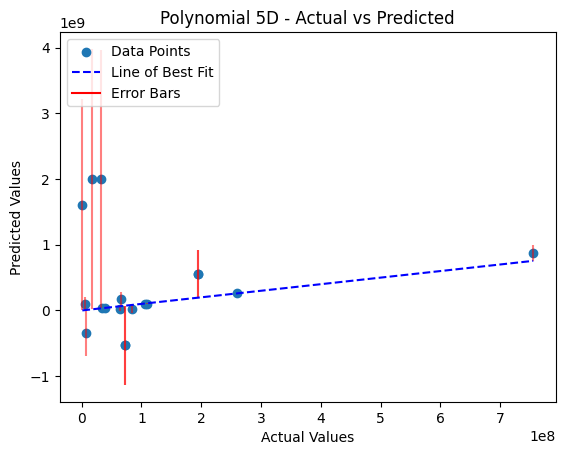

In [32]:
plot_model(y_pred_5d, "Polynomial 5D")

In [19]:
random_forest_regressor_model = RandomForestRegressor(n_estimators=300, random_state=42)
random_forest_regressor_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_regressor_model.predict(X_test)
print("R-squared score: ", r2_score(y_test, y_pred_random_forest))

R-squared score:  0.5111205895308786


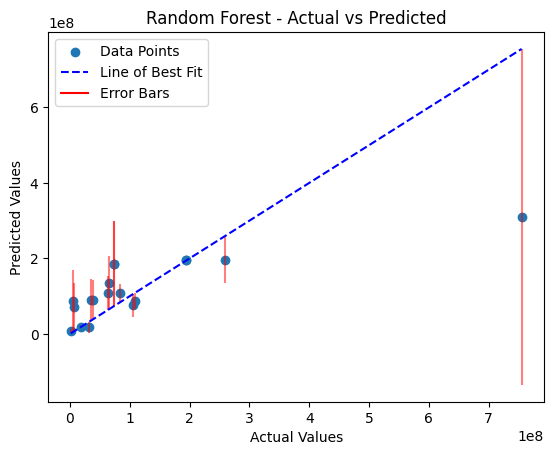

In [20]:
plot_model(y_pred_random_forest, "Random Forest")

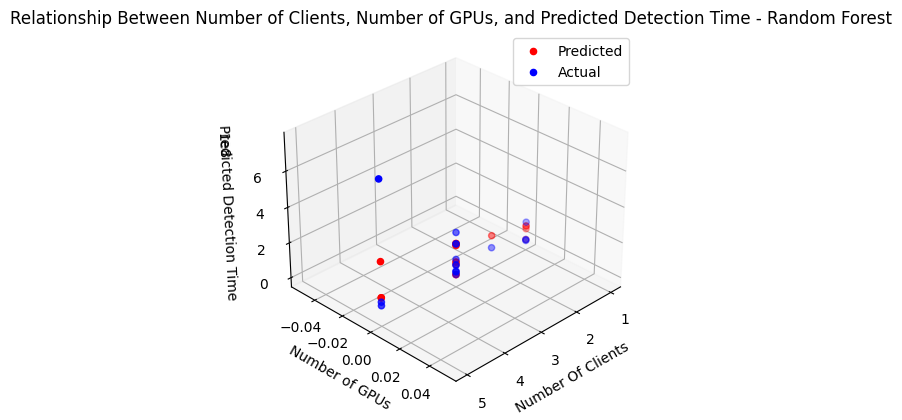

In [21]:
plot_model_3d(y_pred_random_forest, "Random Forest", is_gpu=True)

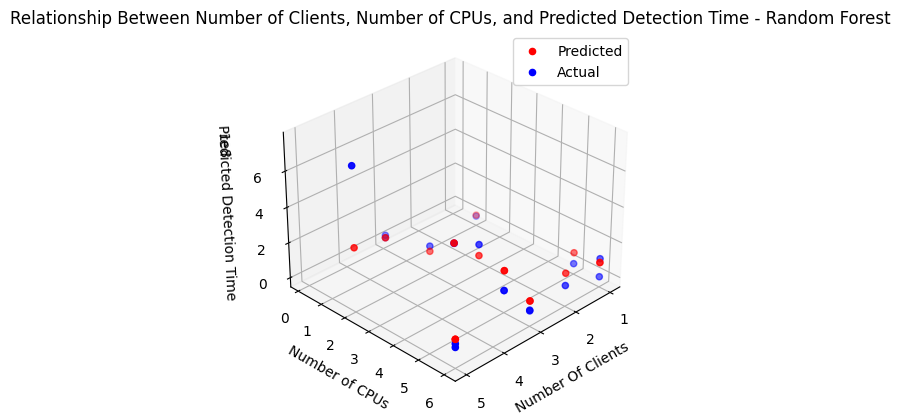

In [22]:
plot_model_3d(y_pred_random_forest, "Random Forest", is_gpu=False)

In [37]:
decision_tree_regressor_model = DecisionTreeRegressor()
decision_tree_regressor_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_regressor_model.predict(X_test)
print("R-squared score: ", r2_score(y_test, y_pred_decision_tree))

R-squared score:  -0.13647826013582565


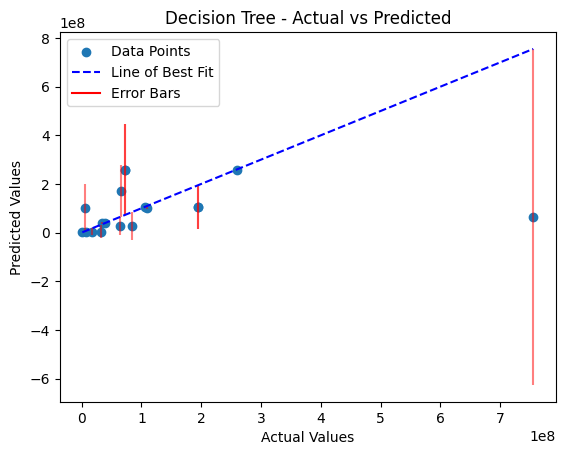

In [38]:
plot_model(y_pred_decision_tree, "Decision Tree")

In [39]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
print("R-squared score: ", r2_score(y_test, y_pred_ridge))

R-squared score:  0.21504422624168196


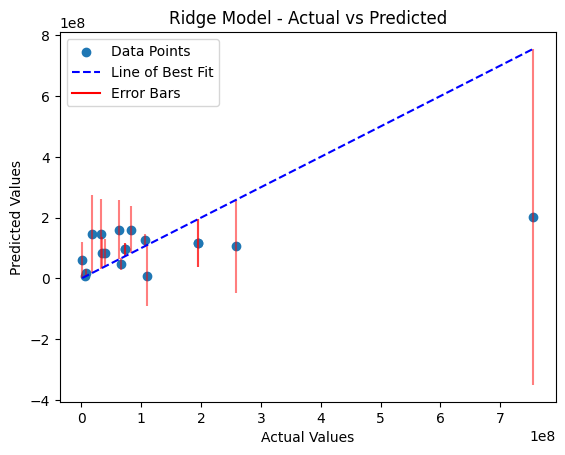

In [40]:
plot_model(y_pred_ridge, "Ridge Model")

In [41]:
lasso_model = Lasso(alpha=0.5)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
print("R-squared score: ", r2_score(y_test, y_pred_lasso))

R-squared score:  0.2175698494923205


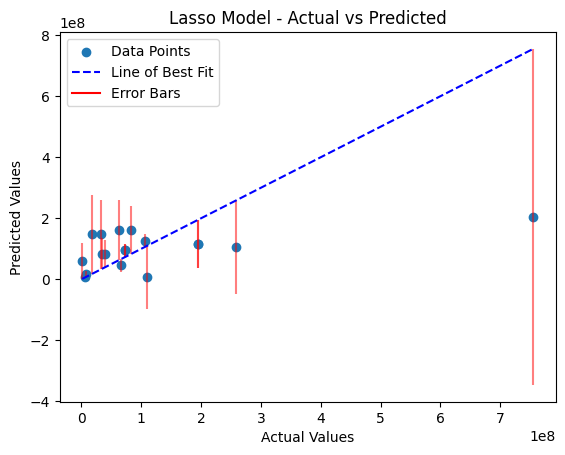

In [42]:
plot_model(y_pred_lasso, "Lasso Model")

In [43]:
elastic_net_model = ElasticNet(alpha=0.2, l1_ratio=0.9)
elastic_net_model.fit(X_train, y_train)
y_pred_elastic_net = elastic_net_model.predict(X_test)
print("R-squared score: ", r2_score(y_test, y_pred_elastic_net))

R-squared score:  0.21671176861135177


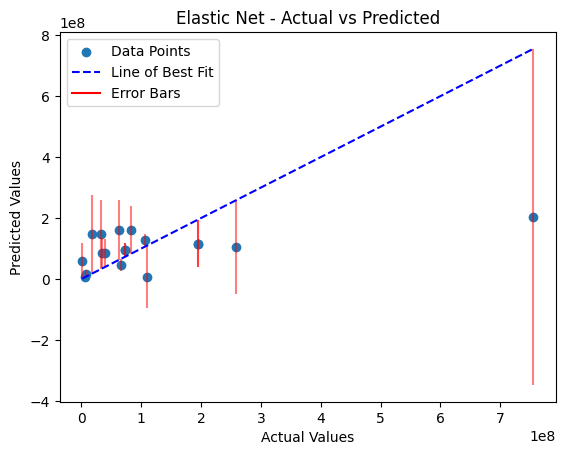

In [44]:
plot_model(y_pred_elastic_net, "Elastic Net")

In [45]:
svm_model = SVR(kernel='poly', C=100, epsilon=100)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("R-squared score: ", r2_score(y_test, y_pred_svm))

R-squared score:  -0.21675755593104884


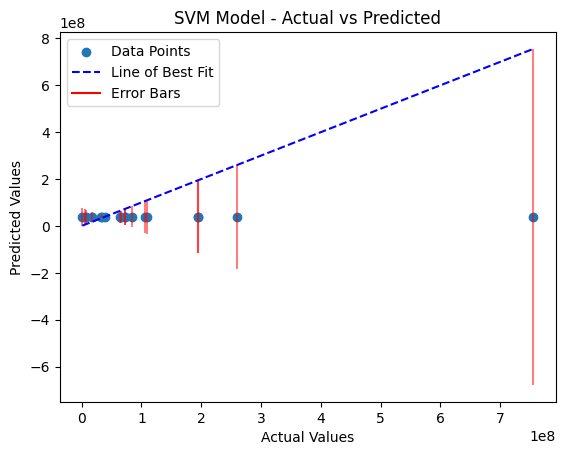

In [46]:
plot_model(y_pred_svm, "SVM Model")